In [116]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [117]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [118]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [119]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [120]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']

In [121]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [122]:
datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]

# Modelling - Train, test split

In [123]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

## ARIMA Model


### Static forecast using ARIMA


No retraining. We just use the best ARIMA model to forecast for the test set and evaluate.
We use the once-trained best ARIMA model to forecast for the 6 "steps" in one go. 

In [124]:
model = ARIMA(df_train['wPreis'], order=(4, 1, 0))
static_ARIMA = model.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [125]:
static_ARIMA.forecast(steps=nobs) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


148     9.790221
149    10.235383
150     5.506046
151     4.813487
152     6.839276
153     5.841581
Name: predicted_mean, dtype: float64

The ARIMA forecast function does not require an "input" other than the steps, so either
- we can do a static forecast (train once on the entire training dataset) and test the predictions for the required steps to compare with the test dataset or
- train in a walk-forward validation where we retrain the model with every step of the test dataset on the new training set which includes the new observation

In [126]:
fc = static_ARIMA.forecast(steps=nobs) 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [127]:
a = np.array(fc)
test= pd.DataFrame(a, columns=['E'])
df_forecast = pd.DataFrame(a, index=df_test.index[-nobs:], columns=['Predicted_wPreis'])

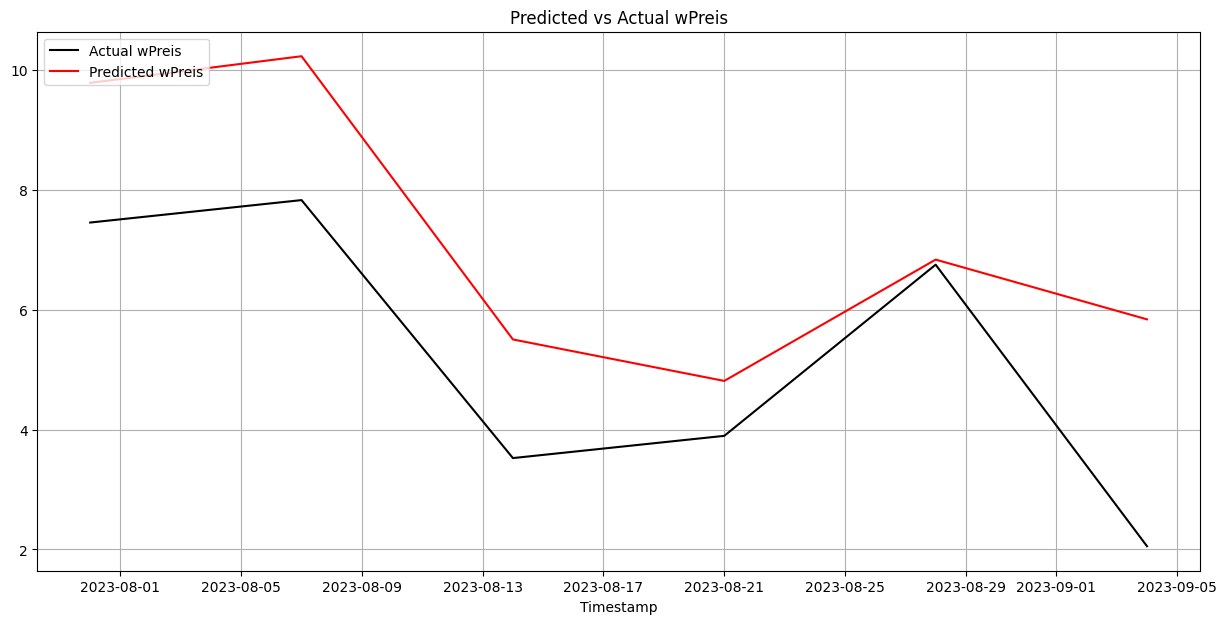

In [128]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 7))
plt.plot(df_test["wPreis"], color='black', label='Actual wPreis')
plt.plot(df_forecast, color='red', label='Predicted wPreis')
plt.xlabel("Timestamp")
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Predicted vs Actual wPreis')
plt.show()

We will define a forecast accuracyy function that will calculate the mean error, RMSE and also the direction accuracy. 

In [129]:
def forecast_accuracy(forecast, actual):
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [130]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(df_forecast['Predicted_wPreis'].values, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: wPreis
me     :  1.9176
rmse   :  2.2485
direction_accuracy :  0.8


## Trying ~~ comparison with rolling window ~~ (not relevant)

In [131]:
window = df_train['wPreis'][-4:].tolist() 

In [132]:
# one-step out of sample forecast
start_index = len(df_train)
end_index = len(df_train)
static_ARIMA.predict(start=start_index, end=end_index)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


148    9.790221
dtype: float64

In [133]:
test = df_test['wPreis'].tolist()

In [134]:
rolling_predictions = list()
rolling_expect=[]

# Iterate over each step in the test set
for t in range(len(test)):
    output = static_ARIMA.predict(start=start_index+t, end=end_index+t)  # Going through each of the t and predicting for that tth step. 
    obs = test[t]
    rolling_predictions.append(output)
    print(rolling_predictions)


[148    9.790221
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64, 151    4.813487
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64, 151    4.813487
dtype: float64, 152    6.839276
dtype: float64]
[148    9.790221
dtype: float64, 149    10.235383
dtype: float64, 150    5.506046
dtype: float64, 151    4.813487
dtype: float64, 152    6.839276
dtype: float64, 153    5.841581
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction r

 Now we get the same as static forecast. Which again suggests that there is no meaning to a rolling forecast without retraining. And retraining would be the walk-forward validation. 

# Walk forward validation using ARIMA model

Training the whole model at each iteration including the new observation (for the next day)  

In [135]:
X = TS1_A1A2["wPreis"].values

Take 148 observations for training and 6 for testing.

In [136]:
size = 148
train, test = X[0:size], X[size:len(X)] 

In [137]:
history = [x for x in train] # "list comprehensions". 
expect=[]

In [138]:
predictions = list()
for t in range(len(test)): # 6 times reiterate
    model = ARIMA(history, order=(4,1,0))  
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs) # appends the real observation at each loop! 
    expect.append(obs)

    
# print(expect)
# print(predictions)

In [139]:
df_wPreis = pd.DataFrame(
    {'observations': expect,
     'forecast': predictions, 
    })


In [140]:
def adjust(val, length= 10): return str(val).ljust(length) # 10
print('Forecast Accuracy of wPreis')
accuracy_prod = forecast_accuracy(df_wPreis['forecast'].values, df_wPreis['observations'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of wPreis
me         :  0.5185
rmse       :  1.9551
direction_accuracy :  0.4


Here, the me and rmse has improved but the direction_accuracy has decreased even further!

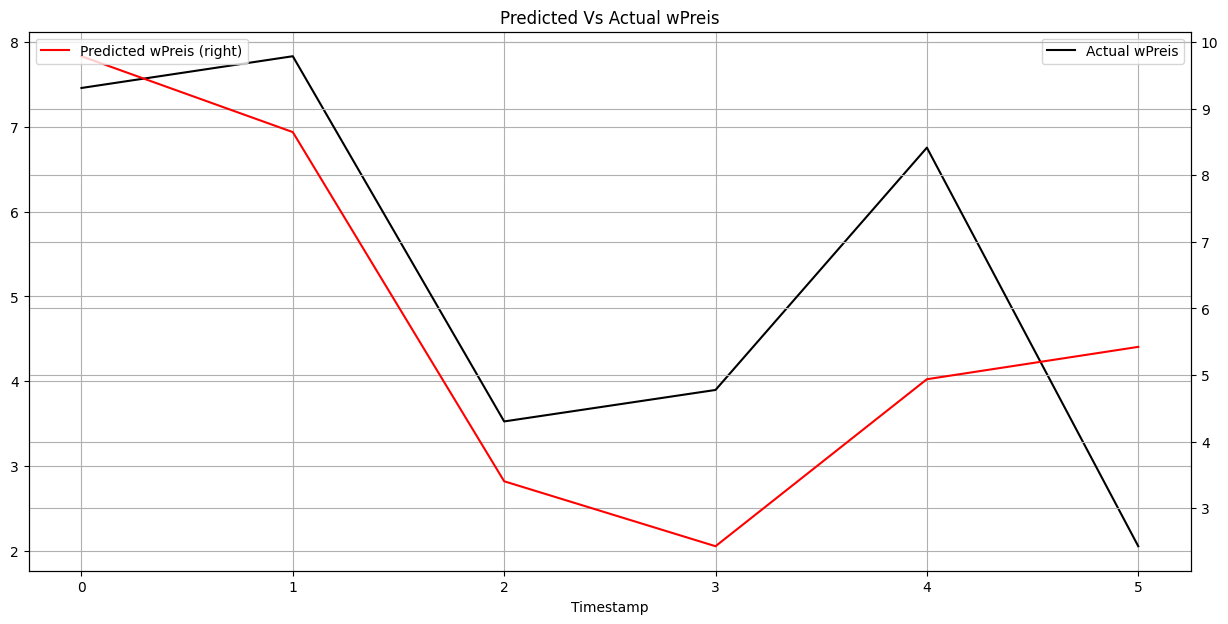

In [141]:
plt.figure(figsize= (15,7))
plt.xlabel("Timestamp")

ax1 = df_wPreis.observations.plot(color = 'black', grid = True, label = 'Actual wPreis')
ax2 = df_wPreis.forecast.plot(color = 'red', grid = True, secondary_y = True, label = 'Predicted wPreis')

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title('Predicted Vs Actual wPreis')
plt.show()

# XGBOOST

In [142]:
from xgboost import XGBRegressor


In [143]:
from pandas import concat


In [144]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [145]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [146]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict(asarray([testX]))
 return yhat[0]

## Walk-forward validation using XGBoost

Retraining model on updated training data, appended at every step to add the new value from test set.

In [147]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
 # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = xgboost_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)

    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy

In [148]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)

In [149]:
import pandas as pd


In [150]:
# transform the time series data into supervised learning
data2 = series_to_supervised(X, n_in=4)

In [151]:
from sklearn.metrics import mean_squared_error


>expected=7.5, predicted=15.1
>expected=7.8, predicted=9.0
>expected=3.5, predicted=6.0
>expected=3.9, predicted=6.1
>expected=6.8, predicted=7.1
>expected=2.1, predicted=4.7
MAE: 2.751
ME: 2.751
RMSE: 3.603
Direction Accuracy: 0.800


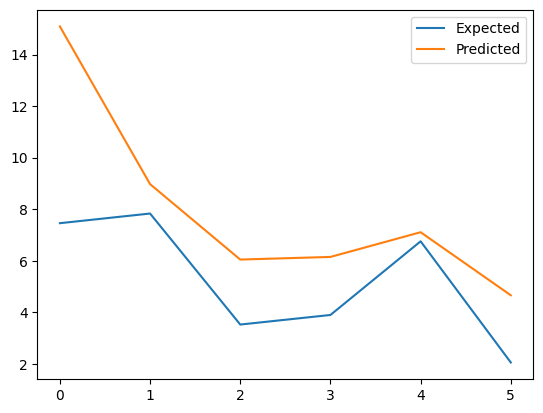

In [152]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = walk_forward_validation(data2, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

The metrics are poorer than Static ARIMA but directino accuracy is similar.

## Static forecast with XGBoost  

The intention was to explore using the XGBoost model to forecast for the 6 "steps" in test set without retraining and evaluate. But there may not be such a thing as static forecasting for XGBoost as the model takes an input which is a 4-day lag here and predicts the next step. To predict the subsequent steps the window has to be moved for input. 

Which means for XGBoost, there is just rolling or walk-forward validation.

In [153]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)

In [154]:
# transform the time series data into supervised learning
data = series_to_supervised(X, n_in=4)

In [155]:
train, test = train_test_split(data, 6)


In [156]:
train = asarray(train)

In [157]:
testX, testy = test[0, :-1], test[0, -1]

In [158]:
# Training XGBoost on entire training data once.

train, test = train_test_split(data, 6)

train = asarray(train)
 # split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
static = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
static_model = static.fit(trainX, trainy)


In [159]:
# make a one-step prediction
yhat = static_model.predict(asarray([testX]))
yhat[0]

15.090609

In [160]:
testX2, testy2 = test[1, :-1], test[1, -1]


In [161]:
yhat2 = static_model.predict(asarray([testX2]))
yhat2[0]

5.584712

In [162]:
predictions = list()
direction_accuracies = list() 
for i in range(len(test)):
# split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
# fit model on history and make a prediction
    yhat = static_model.predict(asarray([testX]))
# store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))

>expected=7.5, predicted=15.1
>expected=7.8, predicted=5.6
>expected=3.5, predicted=4.8
>expected=3.9, predicted=5.8
>expected=6.8, predicted=4.3
>expected=2.1, predicted=2.8


In [163]:
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

MAE: 2.751
ME: 1.139
RMSE: 3.529
Direction Accuracy: 0.600


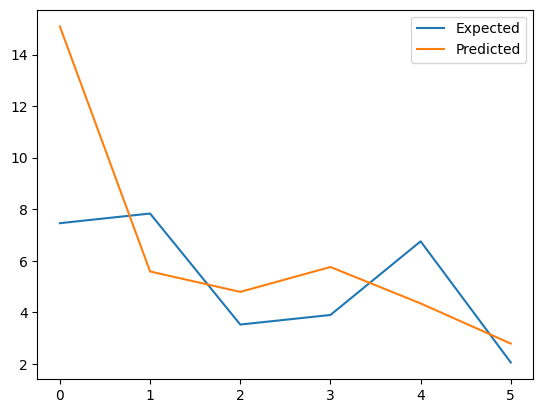

In [164]:
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(test[:, -1], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

Here the ME is less but RMSE is higher. And Direction Accuracy is lower.

### Rolling window forecast for XGBoost

In [165]:

predictions = list()
direction_accuracies = list() 
# step over each time-step in the test set
for i in range(len(test)):
# split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = static_model.predict(asarray([testX]))
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
error = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

#return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy

>expected=7.5, predicted=15.1
>expected=7.8, predicted=5.6
>expected=3.5, predicted=4.8
>expected=3.9, predicted=5.8
>expected=6.8, predicted=4.3
>expected=2.1, predicted=2.8


In [166]:
error = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

MAE: 2.692
ME: 1.139
RMSE: 3.529
Direction Accuracy: 0.600


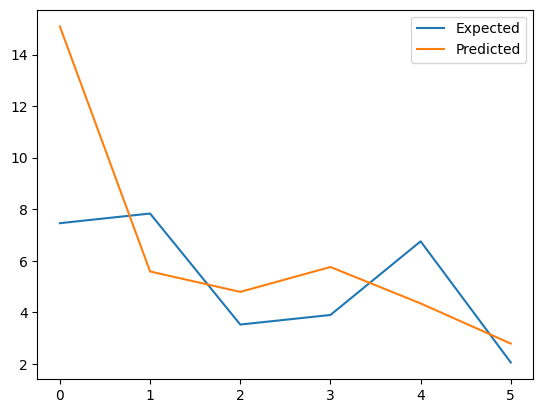

In [167]:
print('MAE: %.3f' % error)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(test[:, -1], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

# Random Forest

Tree based models can only predict within the range of training data. This implies that we cannot just fit a Decision Tree or Random Forest to model auto-regressive dependencies.

### Walk-forward validation

In [168]:
# walk-forward validation for univariate data
def rf_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = random_forest_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [169]:
from sklearn.ensemble import RandomForestRegressor

In [170]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=1000)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 return yhat[0]

In [171]:
TS1_A1A2["wPreis"].values
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)


In [172]:
TS1_A1A2["wPreis"].values


array([-37.51931788, -28.69009585, -29.68807862, -25.6304334 ,
       -29.07379398, -24.93642602, -35.26209517, -28.06563229,
       -27.35874871, -28.21685813, -29.18520815, -32.36064526,
       -20.27214677, -18.80845203, -35.43666563, -23.58340467,
       -23.06625847, -22.99784234, -31.41962306, -25.46027349,
       -23.68194297, -21.47771259, -27.02904785, -24.82276444,
       -23.25520954, -25.32197924, -22.30413021, -23.38024324,
       -25.17015002, -20.85821571, -23.60348981, -24.86044273,
       -23.64540855, -25.72826243, -20.17778383, -26.36851112,
       -21.90534062, -23.64226891, -25.04513087, -24.65590187,
       -21.77319638, -24.9461431 , -23.90837982, -25.23754357,
       -19.73324755, -24.54094226, -24.73818078, -22.97021231,
       -19.21154856, -16.66741517, -26.54786465, -22.45099313,
       -22.93310518, -23.38212367, -23.28028169, -26.65816299,
       -22.07703349, -17.78619097, -18.98931101,  -7.41127285,
        -6.21131882,  -1.98035287,   1.61215148,   0.48

In [173]:
X

array([[-37.51931788],
       [-28.69009585],
       [-29.68807862],
       [-25.6304334 ],
       [-29.07379398],
       [-24.93642602],
       [-35.26209517],
       [-28.06563229],
       [-27.35874871],
       [-28.21685813],
       [-29.18520815],
       [-32.36064526],
       [-20.27214677],
       [-18.80845203],
       [-35.43666563],
       [-23.58340467],
       [-23.06625847],
       [-22.99784234],
       [-31.41962306],
       [-25.46027349],
       [-23.68194297],
       [-21.47771259],
       [-27.02904785],
       [-24.82276444],
       [-23.25520954],
       [-25.32197924],
       [-22.30413021],
       [-23.38024324],
       [-25.17015002],
       [-20.85821571],
       [-23.60348981],
       [-24.86044273],
       [-23.64540855],
       [-25.72826243],
       [-20.17778383],
       [-26.36851112],
       [-21.90534062],
       [-23.64226891],
       [-25.04513087],
       [-24.65590187],
       [-21.77319638],
       [-24.9461431 ],
       [-23.90837982],
       [-25

In [174]:
rf_data = series_to_supervised(X, n_in=4)

>expected=7.5, predicted=15.1
>expected=7.8, predicted=8.6
>expected=3.5, predicted=10.0
>expected=3.9, predicted=7.4
>expected=6.8, predicted=6.6
>expected=2.1, predicted=6.5
MAE: 3.810
ME: 3.765
RMSE: 4.684
Direction Accuracy: 0.200


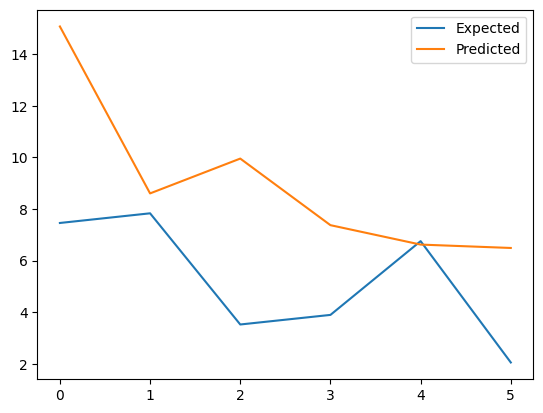

In [175]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = rf_walk_forward_validation(data, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

### Static forecast for Random Forest (should be ROLLING WINDOW)

In [176]:
# fit an random forest model and make a one step prediction
# def random_forest_static_forecast(train, testX):
 # transform list into array
train = asarray(train)
 # split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
model_rf_static = RandomForestRegressor(n_estimators=1000)
model_rf_static.fit(trainX, trainy)
 # make a one-step prediction

RandomForestRegressor(n_estimators=1000)

In [177]:
# 
def rf_staticforecast(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = model_rf_static.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [178]:
rf_static_data = series_to_supervised(X, n_in=4)

>expected=7.5, predicted=15.6
>expected=7.8, predicted=8.3
>expected=3.5, predicted=11.5
>expected=3.9, predicted=7.0
>expected=6.8, predicted=6.7
>expected=2.1, predicted=5.3
Forecast accuracy for Static Forecast with Random Forest
ME: 3.811
RMSE: 5.001
Direction Accuracy: 0.200


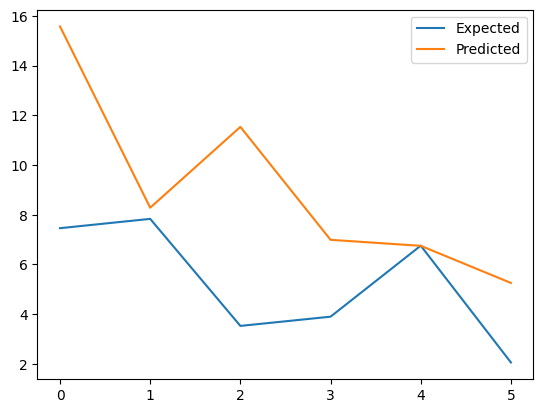

In [179]:
# evaluate
mae, me, rmse, y, yhat, direction_accuracy = rf_staticforecast(rf_static_data, 6)
#print('MAE: %.3f' % mae)
print('Forecast accuracy for Static Forecast with Random Forest')
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

Can recommend models based on what is needed - metrics or accuracy. 

## Decision Tree

In [180]:
from sklearn.tree import DecisionTreeRegressor

In [181]:
n_lags = 4

In [182]:
y_train = df_train['wPreis'].values


In [183]:
y_train

array([-37.51931788, -28.69009585, -29.68807862, -25.6304334 ,
       -29.07379398, -24.93642602, -35.26209517, -28.06563229,
       -27.35874871, -28.21685813, -29.18520815, -32.36064526,
       -20.27214677, -18.80845203, -35.43666563, -23.58340467,
       -23.06625847, -22.99784234, -31.41962306, -25.46027349,
       -23.68194297, -21.47771259, -27.02904785, -24.82276444,
       -23.25520954, -25.32197924, -22.30413021, -23.38024324,
       -25.17015002, -20.85821571, -23.60348981, -24.86044273,
       -23.64540855, -25.72826243, -20.17778383, -26.36851112,
       -21.90534062, -23.64226891, -25.04513087, -24.65590187,
       -21.77319638, -24.9461431 , -23.90837982, -25.23754357,
       -19.73324755, -24.54094226, -24.73818078, -22.97021231,
       -19.21154856, -16.66741517, -26.54786465, -22.45099313,
       -22.93310518, -23.38212367, -23.28028169, -26.65816299,
       -22.07703349, -17.78619097, -18.98931101,  -7.41127285,
        -6.21131882,  -1.98035287,   1.61215148,   0.48

In [184]:
df_y_train = pd.DataFrame(y_train)


In [185]:
shifted_dfs = [df_y_train.shift(t) for t in range(1, n_lags)]
shifted_dfs

[             0
 0          NaN
 1   -37.519318
 2   -28.690096
 3   -29.688079
 4   -25.630433
 ..         ...
 143  25.673098
 144  22.501691
 145  18.514178
 146  28.985554
 147  16.847234
 
 [148 rows x 1 columns],
              0
 0          NaN
 1          NaN
 2   -37.519318
 3   -28.690096
 4   -29.688079
 ..         ...
 143  27.248645
 144  25.673098
 145  22.501691
 146  18.514178
 147  28.985554
 
 [148 rows x 1 columns],
              0
 0          NaN
 1          NaN
 2          NaN
 3   -37.519318
 4   -28.690096
 ..         ...
 143  34.003188
 144  27.248645
 145  25.673098
 146  22.501691
 147  18.514178
 
 [148 rows x 1 columns]]

In [186]:
for df in shifted_dfs:
    print(df.shape)

(148, 1)
(148, 1)
(148, 1)


In [187]:
concatenated_df = pd.concat(shifted_dfs, axis=1)


In [188]:
concatenated_df

,0,0,0
0,NaN,NaN,NaN
1,-37.519318,NaN,NaN
2,-28.690096,-37.519318,NaN
3,-29.688079,-28.690096,-37.519318
4,-25.630433,-29.688079,-28.690096
...,...,...,...
143,25.673098,27.248645,34.003188
144,22.501691,25.673098,27.248645
145,18.514178,22.501691,25.673098
146,28.985554,18.514178,22.501691


In [189]:
diff_df = concatenated_df.diff()
diff_df

,0,0,0
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,8.829222,NaN,NaN
3,-0.997983,8.829222,NaN
4,4.057645,-0.997983,8.829222
...,...,...,...
143,-1.575547,-6.754543,-0.469350
144,-3.171408,-1.575547,-6.754543
145,-3.987512,-3.171408,-1.575547
146,10.471376,-3.987512,-3.171408


In [190]:
diff_values = diff_df.values

# Step 6: Slice the numpy array to exclude the first n_lags rows
sliced_values = diff_values[n_lags:, :]
sliced_values

array([[ 4.05764522e+00, -9.97982775e-01,  8.82922203e+00],
       [-3.44336058e+00,  4.05764522e+00, -9.97982775e-01],
       [ 4.13736796e+00, -3.44336058e+00,  4.05764522e+00],
       [-1.03256692e+01,  4.13736796e+00, -3.44336058e+00],
       [ 7.19646288e+00, -1.03256692e+01,  4.13736796e+00],
       [ 7.06883583e-01,  7.19646288e+00, -1.03256692e+01],
       [-8.58109420e-01,  7.06883583e-01,  7.19646288e+00],
       [-9.68350023e-01, -8.58109420e-01,  7.06883583e-01],
       [-3.17543711e+00, -9.68350023e-01, -8.58109420e-01],
       [ 1.20884985e+01, -3.17543711e+00, -9.68350023e-01],
       [ 1.46369474e+00,  1.20884985e+01, -3.17543711e+00],
       [-1.66282136e+01,  1.46369474e+00,  1.20884985e+01],
       [ 1.18532610e+01, -1.66282136e+01,  1.46369474e+00],
       [ 5.17146191e-01,  1.18532610e+01, -1.66282136e+01],
       [ 6.84161372e-02,  5.17146191e-01,  1.18532610e+01],
       [-8.42178072e+00,  6.84161372e-02,  5.17146191e-01],
       [ 5.95934957e+00, -8.42178072e+00

In [191]:
for t in range(1,n_lags):
    test = pd.DataFrame(y_train).shift(t)

In [192]:
test

,0
0,NaN
1,NaN
2,NaN
3,-37.519318
4,-28.690096
...,...
143,34.003188
144,27.248645
145,25.673098
146,22.501691


In [194]:
X_train_shift = pd.concat([pd.DataFrame(y_train).shift(t) for t in range(1,n_lags)],1).diff().values[n_lags:,:]
y_train_shift = np.diff(y_train)[n_lags-1:]

In [195]:
y_test = df_test['wPreis'].values


In [196]:
tree = DecisionTreeRegressor(max_depth = 2)
tree.fit(X_train_shift, y_train_shift)


DecisionTreeRegressor(max_depth=2)

In [197]:
y_pred_train = tree.predict(X_train_shift).reshape(-1)

In [198]:
Xt = np.concatenate([X_train_shift[-1,1:].reshape(1,-1),np.array(y_train_shift[-1]).reshape(1,1)],1)


In [199]:
predictions_test = []
for t in range(len(y_test)):
    pred = tree.predict(Xt)
    predictions_test.append(pred[0])
    Xt = np.concatenate([np.array(pred).reshape(1,1),Xt[-1,1:].reshape(1,-1)],1)

In [200]:
y_pred_test = np.array(predictions_test)
y_pred_train = y_train[n_lags-2]+np.cumsum(y_pred_train)
y_pred_test = y_train[-1]+np.cumsum(y_pred_test)

In [201]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(y_pred_test, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Decision Tree Forecast Accuracy of: wPreis
me     :  0.3503
rmse   :  3.6113
direction_accuracy :  0.6


## Prophet

In [202]:
import prophet

In [203]:
from prophet import Prophet

In [204]:
df_train.head()

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A1 & A2 - geschreddert,2020-09-14
2020-09-28,2020-39,-28.690096,"['25', '24']",A1 & A2 - geschreddert,2020-09-28
2020-10-12,2020-41,-29.688079,"['25', '24']",A1 & A2 - geschreddert,2020-10-12
2020-10-19,2020-42,-25.630433,"['25', '24']",A1 & A2 - geschreddert,2020-10-19
2020-10-26,2020-43,-29.073794,"['25', '24']",A1 & A2 - geschreddert,2020-10-26


Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
- Datetime column named: ds
- target : y

In [278]:
#pjme_train_prophet = df_train.reset_index() 
pjme_train_prophet = df_train.rename(columns={'date':'ds',
                     'wPreis':'y'})
pjme_train_prophet = pjme_train_prophet[['ds', 'y']]

In [206]:
pjme_train_prophet.head()

,ds,y
date,,
2020-09-14,2020-09-14,-37.519318
2020-09-28,2020-09-28,-28.690096
2020-10-12,2020-10-12,-29.688079
2020-10-19,2020-10-19,-25.630433
2020-10-26,2020-10-26,-29.073794


In [207]:
model = Prophet()


In [208]:
model.fit(pjme_train_prophet)

17:21:43 - cmdstanpy - INFO - Chain [1] start processing
17:21:43 - cmdstanpy - INFO - Chain [1] done processing


In [279]:
#pjme_train_prophet = df_train.reset_index() 
pjme_test_prophet = df_test.rename(columns={'date':'ds',
                     'wPreis':'y'})

pjme_test_prophet = pjme_test_prophet[['ds', 'y']]

In [261]:
pjme_test_fcst = model.predict(pjme_test_prophet)

In [271]:
pjme_test_prophet #.iloc[[0]]

,ds,y
date,,
2023-07-31,2023-07-31,7.458214
2023-08-07,2023-08-07,7.832750
2023-08-14,2023-08-14,3.525113
2023-08-21,2023-08-21,3.896402
2023-08-28,2023-08-28,6.754483
2023-09-04,2023-09-04,2.053265


In [ ]:
pjme_test_fcst = model.predict(pjme_test_prophet[])

In [262]:
pjme_test_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-07-31,57.045772,33.303110,64.551407,57.045772,57.045772,-7.745965,-7.745965,-7.745965,-7.745965,-7.745965,-7.745965,0.0,0.0,0.0,49.299807
1,2023-08-07,57.631828,37.148638,68.568213,57.629633,57.633452,-4.252795,-4.252795,-4.252795,-4.252795,-4.252795,-4.252795,0.0,0.0,0.0,53.379034
2,2023-08-14,58.217884,40.879967,73.386507,58.212511,58.222141,-1.755968,-1.755968,-1.755968,-1.755968,-1.755968,-1.755968,0.0,0.0,0.0,56.461917
3,2023-08-21,58.803941,43.292143,74.536446,58.793902,58.813257,-0.152457,-0.152457,-0.152457,-0.152457,-0.152457,-0.152457,0.0,0.0,0.0,58.651484
4,2023-08-28,59.389997,45.376744,75.914898,59.373737,59.405520,1.240705,1.240705,1.240705,1.240705,1.240705,1.240705,0.0,0.0,0.0,60.630702
5,2023-09-04,59.976053,46.816888,79.401395,59.954640,59.996760,2.720408,2.720408,2.720408,2.720408,2.720408,2.720408,0.0,0.0,0.0,62.696461


In [267]:
pjme_test_fcst['yhat'][0]

49.29980705761625

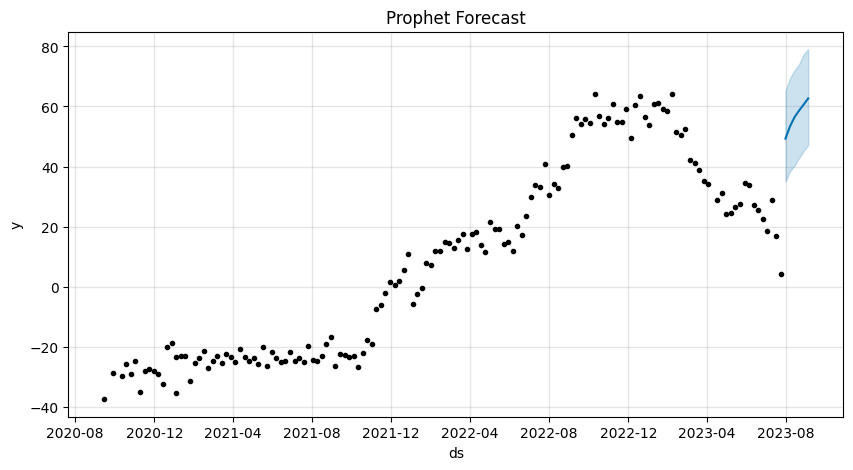

In [212]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

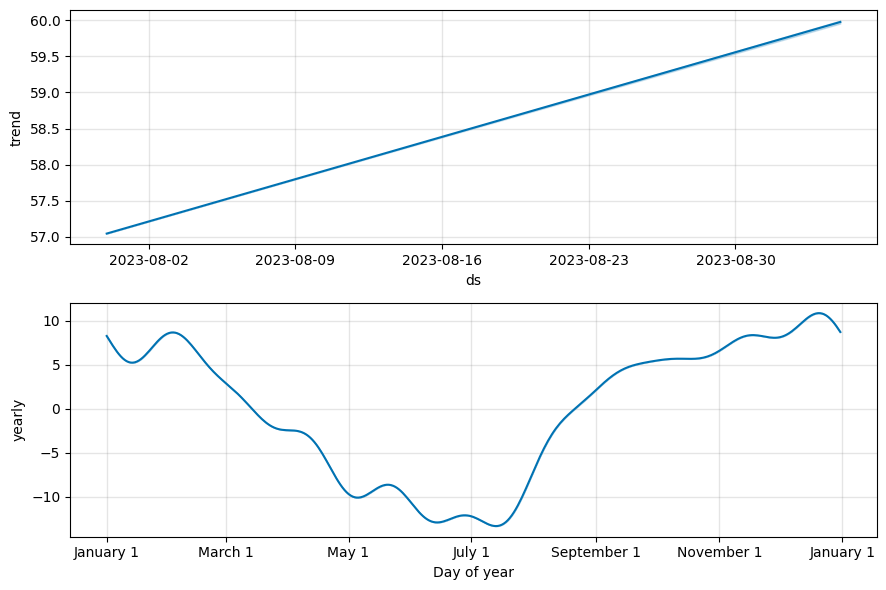

In [213]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

In [214]:
def forecast_accuracy(forecast, actual):
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [215]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Prophet Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(pjme_test_fcst['yhat'].values, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Prophet Forecast Accuracy of: wPreis
me     :  51.5999
rmse   :  51.9709
direction_accuracy :  0.6


In [216]:
df_test['wPreis']

date
2023-07-31    7.458214
2023-08-07    7.832750
2023-08-14    3.525113
2023-08-21    3.896402
2023-08-28    6.754483
2023-09-04    2.053265
Name: wPreis, dtype: float64

In [217]:
pjme_test_fcst['yhat']

0    49.299807
1    53.379034
2    56.461917
3    58.651484
4    60.630702
5    62.696461
Name: yhat, dtype: float64

In [218]:
pjme_test_fcst.index = df_test.index

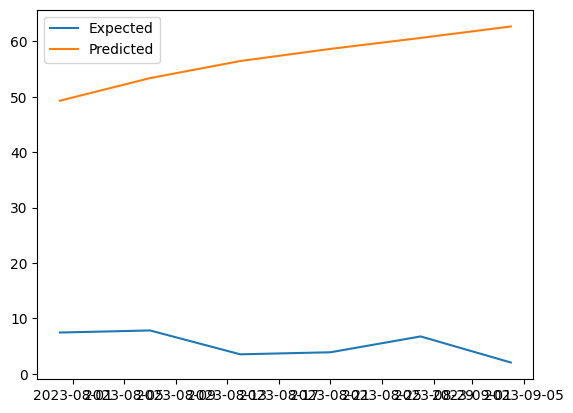

In [219]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(pjme_test_fcst['yhat'], label='Predicted')
plt.legend()
plt.show()

Prophet is wildly wrong.

Trying with Walkforward validation

In [221]:
df_train.head()

,week,wPreis,Plz,full,date
date,,,,,
2020-09-14,2020-37,-37.519318,"['25', '24']",A1 & A2 - geschreddert,2020-09-14
2020-09-28,2020-39,-28.690096,"['25', '24']",A1 & A2 - geschreddert,2020-09-28
2020-10-12,2020-41,-29.688079,"['25', '24']",A1 & A2 - geschreddert,2020-10-12
2020-10-19,2020-42,-25.630433,"['25', '24']",A1 & A2 - geschreddert,2020-10-19
2020-10-26,2020-43,-29.073794,"['25', '24']",A1 & A2 - geschreddert,2020-10-26


In [240]:
for x in pjme_train_prophet:
    print(x) 


ds
y


In [231]:
pjme_train_prophet[147:]

,ds,y
date,,
2023-07-24,2023-07-24,4.063304


In [223]:
len(pjme_test_prophet)

6

In [225]:
pjme_test_prophet[i:]

,ds,y
date,,
2023-09-04,2023-09-04,2.053265


In [234]:
pjme_test_fcst['yhat']

date
2023-07-31    49.299807
2023-08-07    53.379034
2023-08-14    56.461917
2023-08-21    58.651484
2023-08-28    60.630702
2023-09-04    62.696461
Name: yhat, dtype: float64

In [236]:
pjme_train_prophet.append(49.299807)

TypeError: cannot concatenate object of type '<class 'float'>'; only Series and DataFrame objs are valid

In [255]:
history_pr = pjme_train_prophet

In [256]:
history_pr

,ds,y
date,,
2020-09-14,2020-09-14,-37.519318
2020-09-28,2020-09-28,-28.690096
2020-10-12,2020-10-12,-29.688079
2020-10-19,2020-10-19,-25.630433
2020-10-26,2020-10-26,-29.073794
...,...,...
2023-06-26,2023-06-26,22.501691
2023-07-03,2023-07-03,18.514178
2023-07-10,2023-07-10,28.985554


In [273]:
range(len(pjme_test_prophet))

range(0, 6)

In [275]:
test = pjme_train_prophet.append(pjme_test_prophet.iloc[[0]], ignore_index=True)
test

,ds,y
0,2020-09-14,-37.519318
1,2020-09-28,-28.690096
2,2020-10-12,-29.688079
3,2020-10-19,-25.630433
4,2020-10-26,-29.073794
...,...,...
144,2023-07-03,18.514178
145,2023-07-10,28.985554
146,2023-07-17,16.847234
147,2023-07-24,4.063304


In [276]:
test.iloc[[-1]]

,ds,y
148,2023-07-31,7.458214


In [284]:
def pr_walk_forward(train,test):
    predictions = list()
    direction_accuracies = list() 
    forecast_diffs = []
    actual_diffs = []
    direction_accuracies = []
 
    history_pr = train
    for i in range(len(pjme_test_prophet)):
        # split test row into input and output columns
        # testX, testy = df_test[i, :-1], df_test[i, -1]
        # fit model on history and make a prediction
       
        new_model = Prophet()
        new_fit = new_model.fit(history_pr)
        pjme_test_fcst = new_fit.predict(test.iloc[[i]])
        # print('Prophet forecast')
        # print(pjme_test_fcst['yhat'])
        # store forecast in list of predictions
        predictions.append(pjme_test_fcst['yhat'])
        if i > 0:
            forecast_diff = predictions[i] - predictions[i-1]
            actual_diff = test['y'].iloc[i] - test['y'].iloc[i - 1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)

        
        # print('Predictions')
        # print(predictions)
    # add actual observation to history for the next loop
        new_row = test.iloc[[i]]
        # print('New Row')
        # print(new_row)
        history_pr = history_pr.append(new_row, ignore_index=True)
        # print('Appended training set')
        # print(history_pr.iloc[[-1]])

    MEA = mean_absolute_error(test['y'], predictions)
    ME = np.mean(test['y'] - predictions)
    RMSE = np.sqrt(mean_squared_error(test['y'], predictions))
    overall_direction_accuracy = np.mean(direction_accuracies)

    return MEA, ME, RMSE, overall_direction_accuracy


In [285]:
mae, me, rmse, y, yhat, direction_accuracy = pr_walk_forward(pjme_train_prophet, pjme_test_prophet)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(pjme_test_prophet['y'], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Data must be 1-dimensional

In [281]:
predictions

[0    25.069458
 Name: yhat, dtype: float64,
 0    20.923304
 Name: yhat, dtype: float64,
 0    22.912771
 Name: yhat, dtype: float64,
 0    24.116972
 Name: yhat, dtype: float64,
 0    21.111868
 Name: yhat, dtype: float64,
 0    26.107623
 Name: yhat, dtype: float64]

In [ ]:

    # store forecast in list of predictions
    predictions.append(pjme_test_fcst[i])
#     if i > 0:  # Direction accuracy is not applicable for the first prediction
#             forecast_diff = pjme_test_fcst[i] - predictions[-2]
#             actual_diff = testy - pjme_test_prophet[i - 1, -1]
#             direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
#             direction_accuracies.append(direction_accuracy)


In [ ]:

    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 